In [1]:
!pip install pandas requests openpyxl tqdm
import pandas as pd
import requests
from tqdm import tqdm
import os
import sklearn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_excel("")

In [3]:

df['ips'] = df['ips'].astype(str)  
df['ip_list'] = df['ips'].str.split(',')

df_exploded = df.explode('ip_list')

df_exploded['ip_list'] = df_exploded['ip_list'].str.strip()

df_exploded.to_csv("exploded_ips.csv", index=False)

print("Exploded IPs saved to 'exploded_ips.csv'")
print(f"Original rows: {len(df)} → After explode: {len(df_exploded)}")

Exploded IPs saved to 'exploded_ips.csv'
Original rows: 1436 → After explode: 1802


In [4]:
home_dir = os.path.expanduser("")  
output_path = os.path.join(home_dir, "exploded_ips.csv")

# Save the file
df_exploded.to_csv(output_path, index=False)

print(f" File saved to: {output_path}")

 File saved to: C:\Users\Lenovo\Desktop\Group IB\exploded_ips.csv


In [5]:
import time
ipinfo_token = ""  
df_exploded = pd.read_csv("")
enriched_data = []

for ip in tqdm(df_exploded['ip_list'], desc="Enriching IPs"):
    try:
        url = f"https://ipinfo.io/{ip}?token={ipinfo_token}"
        response = requests.get(url)
        data = response.json()

        enriched_data.append({
            "ip": ip,
            "country": data.get("country"),
            "region": data.get("region"),
            "city": data.get("city"),
            "timezone": data.get("timezone"),
            "org": data.get("org")
        })

        time.sleep(0.3)  

    except Exception as e:
        print(f" Error with IP {ip}: {e}")
        enriched_data.append({"ip": ip})  # Still log failed IP

df_enriched = pd.DataFrame(enriched_data)

output_path = os.path.join("")
df_enriched.to_csv(output_path, index=False)

print(f"IP enrichment saved to: {output_path}")

Enriching IPs:  75%|██████████████████████████████████████████████               | 1360/1802 [37:43<1:14:16, 10.08s/it]

 Error with IP 176.59.48.124: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Enriching IPs:  96%|████████████████████████████████████████████████████████████▋  | 1736/1802 [43:24<05:11,  4.72s/it]

 Error with IP 213.87.139.93: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Enriching IPs: 100%|███████████████████████████████████████████████████████████████| 1802/1802 [44:13<00:00,  1.47s/it]

IP enrichment saved to: C:\Users\Lenovo\Desktop\Group IB\ip_enriched.csv


In [6]:
!pip install scikit-learn





[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
#PROFILE 1: Detect identities/devices used across many banks
from sklearn.ensemble import IsolationForest

features = df.groupby("identity")["bank"].nunique().reset_index()
features.columns = ["identity", "bank_count"]
model = IsolationForest(contamination=0.01).fit(features[["bank_count"]])
features["anomaly"] = model.predict(features[["bank_count"]])
features.head(10)


,identity,bank_count,anomaly
0,2577384,1,1
1,13944790,2,1
2,15330202,2,1
3,37294473,1,1
4,56694647,1,1
5,67853893,1,1
6,-,11,-1
7,00010fb5147e6ec14e287ca903cd427339893450,2,1
8,0001130edcec4bc49865eb7818024c05e8831b55,2,1
9,0001b4f1d3677f78b92861745a0db5af4e706c3c,2,1


In [8]:
# how many banks each identity appears in
identity_bank_count = df.groupby('identity')['bank'].nunique().reset_index(name='bank_count')

#  Filter for identities appearing in more than 1 bank
multi_bank_identities = identity_bank_count[identity_bank_count['bank_count'] > 1]

# identities used in multiple banks
print("Identities used across multiple banks:", len(multi_bank_identities))
print(multi_bank_identities.head())

# overlapping identities between Bank8 and Bank9
ids_bank8 = set(df[df['bank'] == 'Bank8']['identity'].unique())
ids_bank9 = set(df[df['bank'] == 'Bank9']['identity'].unique())
shared_ids = ids_bank8 & ids_bank9

print(f"\nShared identities between Bank8 & Bank9: {len(shared_ids)}")
print(list(shared_ids)[:10])  

#taregting "-" fingerprint 
anon_fps = df[df['identity'] == '-']['device_fingerprint'].unique()
print("Fingerprints used by anonymous identity:", anon_fps)

linked_identities = df[df['device_fingerprint'].isin(anon_fps)]['identity'].unique()
print("Other identities that used same device as anonymous:", linked_identities)

linked_banks = df[df['device_fingerprint'].isin(anon_fps)]['bank'].value_counts()
print("Banks where the anonymous fingerprint was used:\n", linked_banks)




Identities used across multiple banks: 11
                                   identity  bank_count
1                                  13944790           2
2                                  15330202           2
6                                         -          11
7  00010fb5147e6ec14e287ca903cd427339893450           2
8  0001130edcec4bc49865eb7818024c05e8831b55           2

Shared identities between Bank8 & Bank9: 1
['-']
Fingerprints used by anonymous identity: ['6413e837d3-987e3415d7-902dcc5844-27c94f86d9'
 '6413e837d3-987e3415d7-0477bed160-27c94f86d9'
 'b48af28979-116c56e539-9b9e431e93-87a831f69f'
 'cd38d47a3e-035b0b3e18-3e9e2f5cfc-56bb7522d8'
 '79f3862c68-0e966a885e-14beccd0a0-009fdfa3aa'
 '53f112cc1e-a6fa059258-61972baeef-4ad926cdc2'
 '53f112cc1e-f3e62aeba0-ef8a92c191-2cd4e7b04b'
 '6413e837d3-987e3415d7-d623bd6f2d-27c94f86d9'
 '79f3862c68-3dc8bb4443-e72fd8cf2a-c2489080bd'
 '79f3862c68-3532db7d37-225094f661-a4a3bd4ab9'
 'cd38d47a3e-f38a167245-c08e906166-dd758f5cb8'
 '1928f95c59-4

   identity                           device_fingerprint  profile2_cluster
0  37294473  b48af28979-116c56e539-9b9e431e93-87a831f69f                 0
1         -  6413e837d3-987e3415d7-902dcc5844-27c94f86d9                 1
2   2577384  6413e837d3-987e3415d7-902dcc5844-27c94f86d9                 1
3   2577384  6413e837d3-987e3415d7-902dcc5844-27c94f86d9                 1
4  37294473  b48af28979-116c56e539-9b9e431e93-87a831f69f                 0
5  37294473  b48af28979-116c56e539-9b9e431e93-87a831f69f                 0
6  37294473  b48af28979-116c56e539-9b9e431e93-87a831f69f                 0
7  67853893  6413e837d3-987e3415d7-0477bed160-27c94f86d9                 2
8  67853893  6413e837d3-987e3415d7-0477bed160-27c94f86d9                 2
9  37294473  b48af28979-116c56e539-9b9e431e93-87a831f69f                 0
profile2_cluster
 40    168
 39    145
 0     103
 31    101
 38     78
 32     77
 1      74
 30     64
 45     61
 4      60
 9      54
-1      49
 49     42
 8      41
 36 

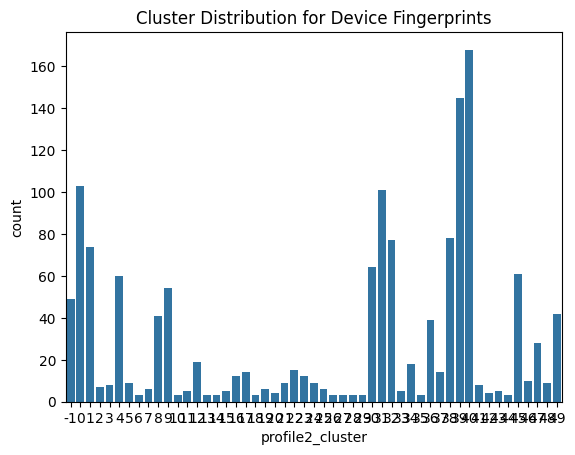

profile2_cluster
 40    84
 39    73
 31    62
 32    48
 38    46
 30    44
-1     18
 8      9
 9      5
 11     5
Name: identity, dtype: int64


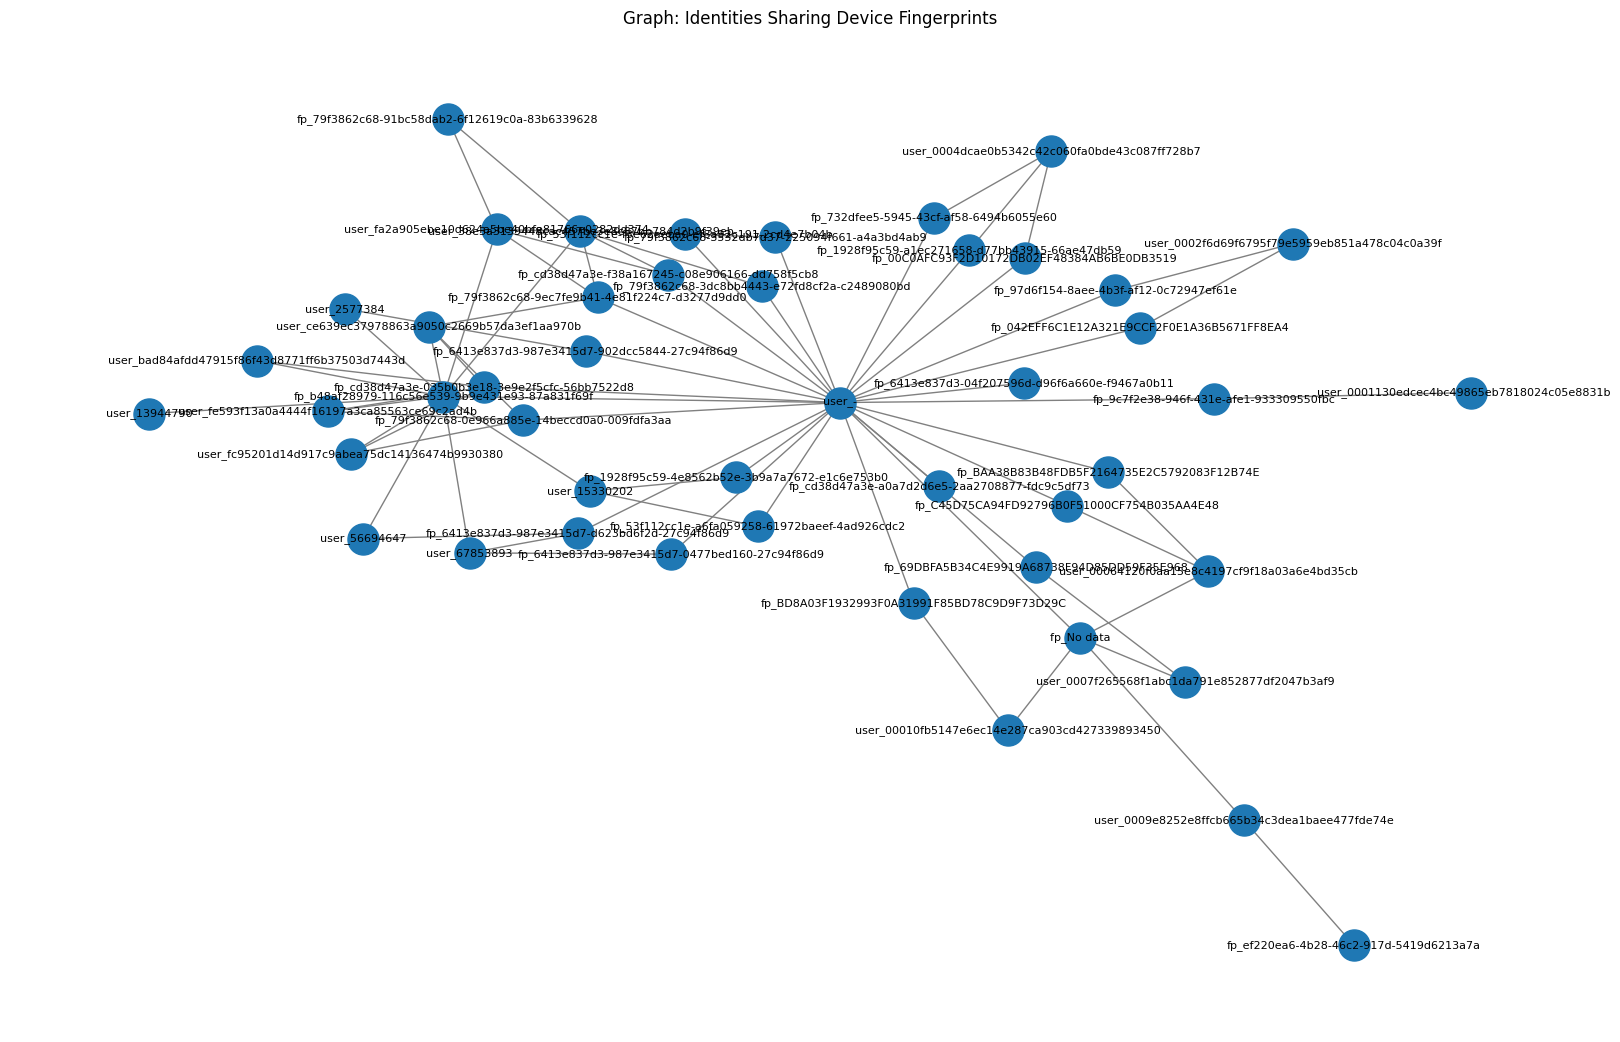

In [9]:
#PROFILE 2 : Device Cloning & Fingerprint Sharing
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# Load enriched dataset
df = pd.read_excel("")

features = ['device_fingerprint', 'gpu_renderers', 'screen', 'os', 'browser']
X = df[features].fillna("unknown").astype(str)

encoder = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), features)
])
X_encoded = encoder.fit_transform(X)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)
df['profile2_cluster'] = dbscan.fit_predict(X_encoded)

# Graph: identity & device_fingerprint
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(f"user_{row['identity']}", f"fingerprint_{row['device_fingerprint']}")

nx.write_gexf(G, "device_fingerprint_network.gexf")

print(df[['identity', 'device_fingerprint', 'profile2_cluster']].head(10))
print(df['profile2_cluster'].value_counts())
sns.countplot(x='profile2_cluster', data=df)
plt.title("Cluster Distribution for Device Fingerprints")
plt.show()

cluster_identities = df.groupby('profile2_cluster')['identity'].nunique().sort_values(ascending=False)
print(cluster_identities.head(10))

df[df['profile2_cluster'] == 0].groupby(['identity']).size()

G = nx.Graph()

for _, row in df.iterrows():
    identity = f"user_{row['identity']}"
    fingerprint = f"fp_{row['device_fingerprint']}"
    G.add_edge(identity, fingerprint)

shared_nodes = [n for n in G.nodes if G.degree[n] > 1]
G_sub = G.subgraph(shared_nodes)

plt.figure(figsize=(16, 10))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw(G_sub, pos, with_labels=True, node_size=500, font_size=8, edge_color='gray')
plt.title("Graph: Identities Sharing Device Fingerprints")
plt.show()



In [10]:


fp_banks = df.groupby('device_fingerprint')['bank'].nunique().reset_index(name='bank_count')
shared_across_banks = fp_banks[fp_banks['bank_count'] > 1]
print(shared_across_banks.head())



                             device_fingerprint  bank_count
7   6413e837d3-04f207596d-d96f6a660e-f9467a0b11           2
25                                      No data           4
26  b48af28979-116c56e539-9b9e431e93-87a831f69f           5


In [11]:
#PROFILE 3 : Emulator or Bot Detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import pandas as pd


profile3_features = ['gpu_renderers', 'screen', 'os', 'browser']
df_profile3 = df[profile3_features].copy()

df_profile3 = df_profile3.fillna("unknown")

df_profile3[['screen_width', 'screen_height']] = df_profile3['screen'].str.extract(r'(\d+)\D+(\d+)', expand=True).astype(float)

# 2. Flag suspicious screen sizes (too small or impossible)
df_profile3['suspicious_screen'] = ((df_profile3['screen_width'] < 600) | 
                                    (df_profile3['screen_height'] < 400) |
                                    (df_profile3['screen_width'] > 3000) |
                                    (df_profile3['screen_height'] > 3000)).astype(int)

df_profile3['gpu_clean'] = df_profile3['gpu_renderers'].str.lower()

known_gpus = ['nvidia', 'amd', 'intel', 'qualcomm', 'mali', 'powervr', 'apple', 'adreno']
df_profile3['is_known_gpu'] = df_profile3['gpu_clean'].apply(lambda x: int(any(k in x for k in known_gpus)))
df_profile3['suspicious_gpu'] = (~df_profile3['is_known_gpu']).astype(int)


encoded_features = df_profile3[['gpu_renderers', 'screen', 'os', 'browser']].fillna("unknown")


encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded = encoder.fit_transform(encoded_features)

iso_forest = IsolationForest(n_estimators=150, contamination=0.05, random_state=42)
df['profile3_score'] = iso_forest.fit_predict(encoded)  # -1 = outlier
df['profile3_if_flag'] = df['profile3_score'].apply(lambda x: 1 if x == -1 else 0)
df['profile3_bot_flag'] = (
    (df_profile3['suspicious_screen'] == 1) |
    (df_profile3['suspicious_gpu'] == 1) |
    (df['profile3_if_flag'] == 1)
).astype(int)


num_bots = df['profile3_bot_flag'].sum()
print(f" Detected {num_bots} suspicious device environments (potential bots/emulators).")

profile3_features += ['profile3_bot_flag']
df[df['profile3_bot_flag'] == 1][profile3_features].value_counts().head(10)


 Detected 708 suspicious device environments (potential bots/emulators).


gpu_renderers         screen          os             browser                            profile3_bot_flag
-                     (780, 360, 24)  Android        Chrome Mobile WebView 78.0.3904    1                    171
                                                     Chrome Mobile WebView 79.0.3945    1                    163
                                                     Chrome Mobile WebView 77.0.3865    1                     80
                      (667, 375, 32)  iOS 13.1.3     Mobile Safari UI/WKWebView 13.1.3  1                     61
                      (720, 360, 24)  Android 8.1.0  Chrome Mobile WebView 79.0.3945    1                     47
                                                     Chrome Mobile WebView 78.0.3904    1                     39
                      (667, 375, 32)  iOS 13.3       Mobile Safari UI/WKWebView 13.3    1                     28
PowerVR Rogue GE8300  (760, 360, 24)  Android        Chrome Mobile 71.0.3578            1              

 Fingerprints reused across 5+ identities:
                            device_fingerprint  identity_count
1  1928f95c59-a1ec271658-d77bb43915-66ae47db59             116
3     C45D75CA94FD92796B0F51000CF754B035AA4E48             195


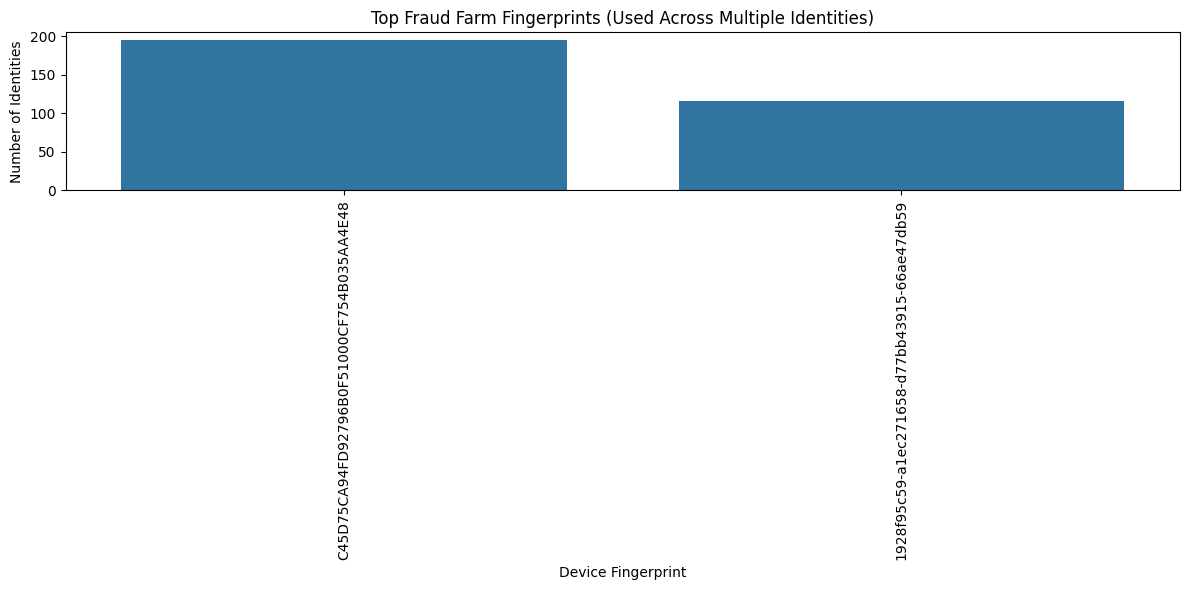

 Saved suspicious fingerprint identities to: fraud_farm_candidates.xlsx


In [12]:
#PROFILE 4 : Fraud Farm Detection in Bank8 & Bank9

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("")


df_target = df[df['bank'].isin(['Bank8', 'Bank9'])].copy()

fingerprint_counts = df_target.groupby('device_fingerprint')['identity'].nunique().reset_index()
fingerprint_counts.columns = ['device_fingerprint', 'identity_count']

fraud_farm_fps = fingerprint_counts[fingerprint_counts['identity_count'] >= 5]
print(" Fingerprints reused across 5+ identities:")
print(fraud_farm_fps.head())

df_fraud_farms = df_target[df_target['device_fingerprint'].isin(fraud_farm_fps['device_fingerprint'])]

plt.figure(figsize=(12, 6))
top_fps = fraud_farm_fps.sort_values('identity_count', ascending=False).head(20)
sns.barplot(x='device_fingerprint', y='identity_count', data=top_fps)
plt.xticks(rotation=90)
plt.title("Top Fraud Farm Fingerprints (Used Across Multiple Identities)")
plt.xlabel("Device Fingerprint")
plt.ylabel("Number of Identities")
plt.tight_layout()
plt.show()

df_fraud_farms.to_excel("", index=False)
print(" Saved suspicious fingerprint identities to: fraud_farm_candidates.xlsx")


In [13]:
#PROFILE 5: Fraud Ring Clusters via Shared IPs and Location Anomalies

import pandas as pd
import os


main_df = pd.read_excel("")


main_df['ips'] = main_df['ips'].astype(str)
main_df['ip_list'] = main_df['ips'].str.split(',')
main_df = main_df.explode('ip_list')
main_df['ip_list'] = main_df['ip_list'].str.strip()


ip_df = pd.read_csv("")


merged_df = main_df.merge(ip_df, left_on='ip_list', right_on='ip', how='left')
print(" Merged dataset shape:", merged_df.shape)

ip_identity_counts = merged_df.groupby('ip_list')['identity'].nunique().reset_index()
ip_identity_counts.columns = ['ip', 'identity_count']
suspicious_ips = ip_identity_counts[ip_identity_counts['identity_count'] >= 10]
many_ids_df = merged_df[merged_df['ip_list'].isin(suspicious_ips['ip'])]
many_ids_path = ""
many_ids_df.to_excel(many_ids_path, index=False)
print(f" Saved suspicious IPs (used by ≥10 identities) to: {many_ids_path}")

merged_df['os_lower'] = merged_df['os'].fillna("").str.lower()
merged_df['timezone_lower'] = merged_df['timezone'].fillna("").str.lower()

def detect_timezone_os_mismatch(row):
    if any(x in row['timezone_lower'] for x in ['moscow', 'ru', 'europe', 'asia']):
        if 'mac' in row['os_lower'] or 'ios' in row['os_lower']:
            return "yes"
    return "no"

merged_df['timezone_os_mismatch'] = merged_df.apply(detect_timezone_os_mismatch, axis=1)
tz_mismatch_df = merged_df[merged_df['timezone_os_mismatch'] == "yes"]
print(f" Timezone-OS mismatches detected: {len(tz_mismatch_df)}")

vpn_org_keywords = ['digitalocean', 'm247', 'amazon', 'google', 'ovh', 'contabo', 'hetzner', 'linode']
merged_df['org_lower'] = merged_df['org'].fillna("").str.lower()
merged_df['vpn_like_org'] = merged_df['org_lower'].apply(lambda org: "yes" if any(k in org for k in vpn_org_keywords) else "no")
vpn_df = merged_df[merged_df['vpn_like_org'] == "yes"]
print(f" VPN-like orgs detected: {len(vpn_df)}")

flagged_countries = ['RU', 'CN', 'IR', 'SG', 'BR']
merged_df['country_flag'] = merged_df['country'].apply(lambda x: "flag" if x in flagged_countries else "ok")
print(" Country flag counts:\n", merged_df['country_flag'].value_counts())

final_output_path = ""
merged_df.to_excel(final_output_path, index=False)
print(f" Final merged + flagged IP analysis saved to: {final_output_path}")


 Merged dataset shape: (10248, 16)
 Saved suspicious IPs (used by ≥10 identities) to: C:\Users\Lenovo\Desktop\Group IB\profile5_many_identities_per_ip.xlsx
 Timezone-OS mismatches detected: 4109
 VPN-like orgs detected: 87
 Country flag counts:
 country_flag
flag    9248
ok      1000
Name: count, dtype: int64
 Final merged + flagged IP analysis saved to: C:\Users\Lenovo\Desktop\Group IB\profile5_final_ip_flags.xlsx


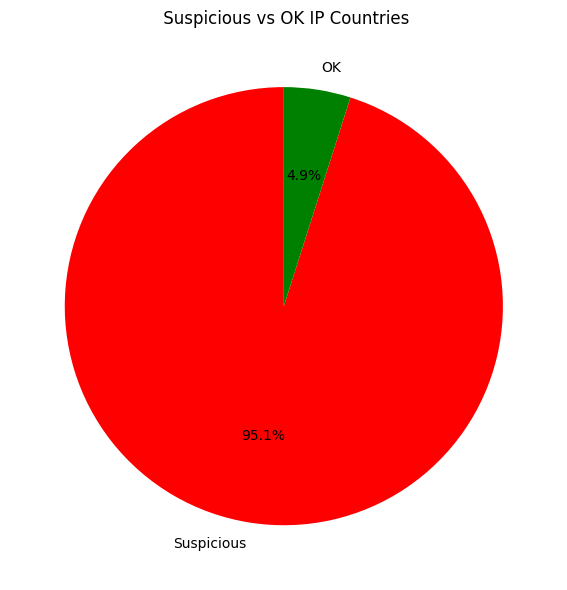

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16744\681684954.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


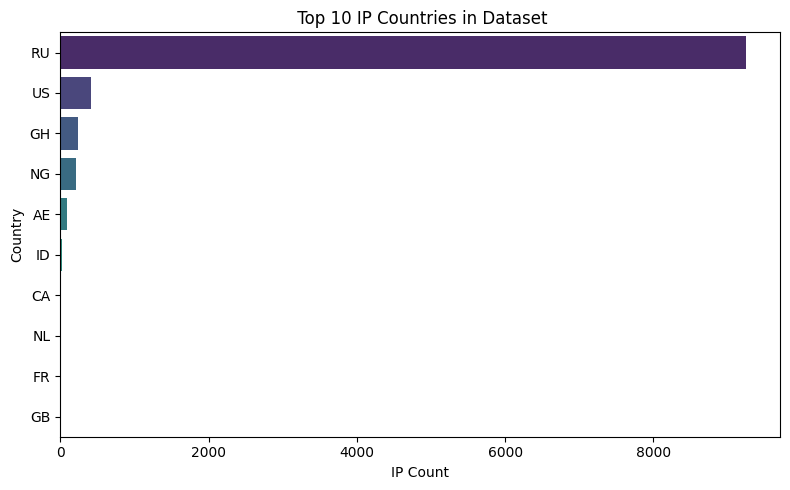

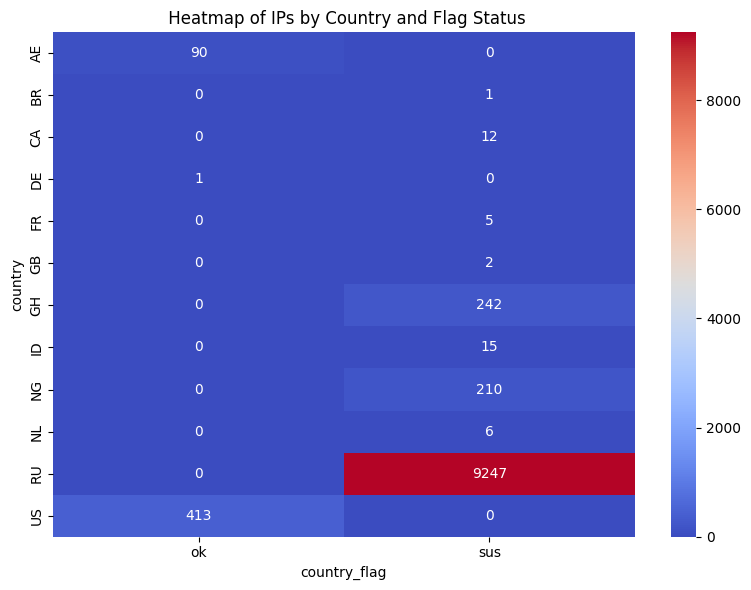

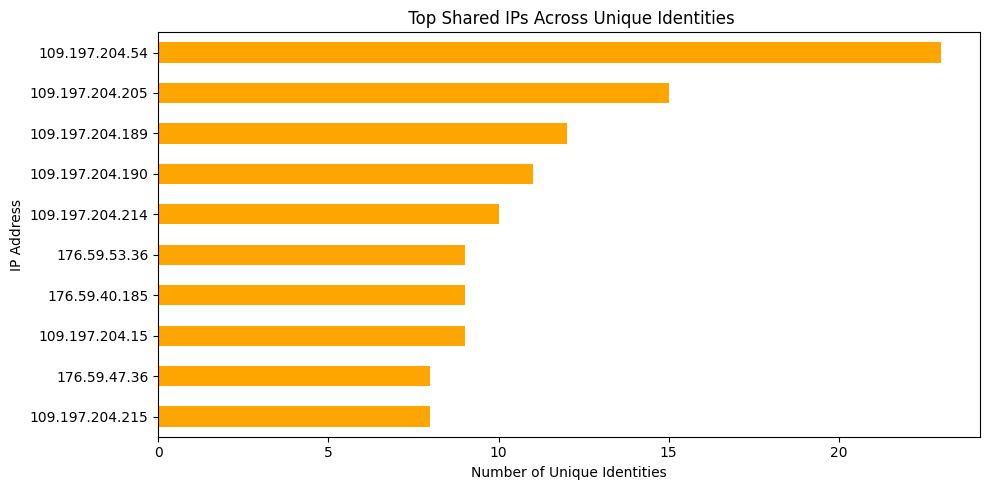

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("")
df_enriched = pd.read_csv("")

df['ips'] = df['ips'].astype(str)
df['ip_list'] = df['ips'].str.split(',')
df_exploded = df.explode('ip_list')
df_exploded['ip_list'] = df_exploded['ip_list'].str.strip()

df_ip_joined = pd.merge(
    df_exploded,
    df_enriched.rename(columns={"ip": "ip_list"}),
    on="ip_list",
    how="left"
)

trusted_countries = ["EG", "AE", "US", "SA", "DE"]  # Customize as needed
df_ip_joined["country_flag"] = df_ip_joined["country"].apply(lambda x: "ok" if x in trusted_countries else "sus")

plt.figure(figsize=(6, 6))
df_ip_joined['country_flag'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['red', 'green'],
    startangle=90,
    labels=['Suspicious', 'OK']
)
plt.title(" Suspicious vs OK IP Countries")
plt.ylabel('')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
top_countries = df_ip_joined['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title(" Top 10 IP Countries in Dataset")
plt.xlabel("IP Count")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
heat_df = df_ip_joined.groupby(['country', 'country_flag']).size().unstack(fill_value=0)
sns.heatmap(heat_df, annot=True, fmt='d', cmap='coolwarm')
plt.title(" Heatmap of IPs by Country and Flag Status")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_shared_ips = df.groupby('ips')['identity'].nunique().sort_values(ascending=False).head(10)
top_shared_ips.plot(kind='barh', color='orange')
plt.title(" Top Shared IPs Across Unique Identities")
plt.xlabel("Number of Unique Identities")
plt.ylabel("IP Address")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
